In [1]:
import pandas as pd
import numpy as np
import datetime
from tensorflow import keras
from keras.models import Sequential
from keras import Input
from keras.layers import Bidirectional, LSTM, Dense, RepeatVector, TimeDistributed
from keras.layers.core import Dense, Dropout, Activation
import matplotlib.pyplot as plt
import matplotlib

# Read in Sentinel A, B data; Read in in-situ data

In [2]:
# Read in Sentinel A data
sentinel_data_A = pd.read_csv("data/Sentinel_3A_water_level_Version0.csv")
sentinel_data_A = sentinel_data_A.rename(
    columns={
        "Date (YYYYMMDD)" : "date",
        "Lake_name" : "lake_name",
        "Latitude" : "latitude",
        "Longitude" : "longitude",
        "Relaive_orbit" : "relative_orbit",
        "Lake water level (m)" : "lake_water_level"
    }
)
# Convert date to date time.
sentinel_data_A.loc[:, "date"] = pd.to_datetime(sentinel_data_A.loc[:, "date"], format="%Y%m%d")

In [3]:
# Read in Sentinel B data
sentinel_data_B = pd.read_csv("data/Sentinel_3B_water_level_Version0.csv")

sentinel_data_B = sentinel_data_B.rename(
    columns={
        "Date (YYYYMMDD)" : "date",
        "Lake_name" : "lake_name",
        "Latitude" : "latitude",
        "Longitude" : "longitude",
        "Relaive_orbit" : "relative_orbit",
        "Lake water level (m)" : "lake_water_level"
    }
)

# Convert date to date time.
sentinel_data_B.loc[:, "date"] = pd.to_datetime(sentinel_data_B.loc[:, "date"], format="%Y%m%d")

In [4]:
# Concatenate
sentinel_data = pd.concat([sentinel_data_A, sentinel_data_B])

In [5]:
# Isolate Lake Winnipeg data
lake_winnipeg = sentinel_data[
    sentinel_data["lake_name"] == "Winnipeg"
]

In [6]:
# Read in-situ data
lake_winnipeg_in_situ = pd.read_csv("./data/WinnipegLake_at_GeorgeIsland.csv")
lake_winnipeg_in_situ = lake_winnipeg_in_situ.rename(
    columns={
        "Date" : "date",
        "Value (m)" : "in_situ_lake_water_level"
    }
)

In [7]:
# Convert date to date time.
lake_winnipeg_in_situ.loc[:, "date"] = pd.to_datetime(lake_winnipeg_in_situ.loc[:, "date"], format="%Y-%m-%d")

# Select only date and in_situ_lake_water_level
lake_winnipeg_in_situ = lake_winnipeg_in_situ[["date", "in_situ_lake_water_level"]]

In [8]:
# Join the data on date
lake_winnipeg = lake_winnipeg.merge(lake_winnipeg_in_situ, on='date', how='left')

In [9]:
lake_winnipeg = lake_winnipeg.loc[
    pd.notnull(lake_winnipeg["in_situ_lake_water_level"])
]

In [10]:
lake_winnipeg.head()

,date,lake_name,latitude,longitude,relative_orbit,lake_water_level,in_situ_lake_water_level
79726,2019-01-10,Winnipeg,53.840506,-98.627263,112,217.231253,217.155
79727,2019-01-10,Winnipeg,53.837662,-98.628729,112,216.901952,217.155
79728,2019-01-10,Winnipeg,53.834818,-98.630195,112,216.901451,217.155
79729,2019-01-10,Winnipeg,53.831974,-98.631661,112,217.006650,217.155
79730,2019-01-10,Winnipeg,53.829131,-98.633126,112,216.928148,217.155


In [11]:
len(lake_winnipeg)

102157

# Reject Outliers

In [12]:
lake_winnipeg["mean_track_lake_water_level"] = lake_winnipeg.groupby("date")["lake_water_level"].transform("mean")
lake_winnipeg["std_track_lake_water_level"] = lake_winnipeg.groupby("date")["lake_water_level"].transform("std")
number_of_standard_deviations = 2 
lake_winnipeg["reject"] = lake_winnipeg.apply(
    lambda row: True if np.abs(
        row["lake_water_level"] - row["mean_track_lake_water_level"]
    ) > number_of_standard_deviations*row["std_track_lake_water_level"] else False,
    axis=1
)
lake_winnipeg = lake_winnipeg.loc[
    lake_winnipeg["reject"] == False
]

In [13]:
lake_winnipeg["reject"].value_counts()

False    99138
Name: reject, dtype: int64

# Find the length of the longest track

In [14]:
# Find the longest track
counts = lake_winnipeg.groupby("date").agg(
    {
        "lake_name" : "count"
    }
)

In [15]:
max(counts["lake_name"])

905

In [16]:
max_track_length = max(counts["lake_name"])

# Adjust the data so every day has max_track_length

In [17]:
df=lake_winnipeg

In [18]:
# Taken from https://stackoverflow.com/questions/68803947/how-do-i-make-each-group-within-a-dataframe-the-same-size
df = df.set_index(["date", df.groupby("date").cumcount()])
index = pd.MultiIndex.from_product(df.index.levels, names=df.index.names)
output = df.reindex(index, fill_value=np.nan).reset_index(level=1, drop=True).reset_index()

In [19]:
# Fill in the rest of the data frame with the first entry for each date for a column
def populate_data_frame_with_first_entry_on_each_date(column):
    output.loc[
        output["date"] == date,
        column
    ] = output.loc[
        output["date"] == date,
        column
    ].iloc[0]

    
number_of_dates = len(pd.unique(output["date"]))

for j, date in enumerate(pd.unique(output["date"])):
    # We padded the array with NaNs to make each date have 920 data points
    # Find out how many non-NaNs we have. This represents the last real data
    # point on each day. E.g. on 2019-01-01 there are 369 real data points
    last_non_null_index = output.loc[
        output["date"] == date,
        "lake_water_level"
    ].count()

    # Get the lake water level on each day as a numpy array
    lake_water_level = np.array(
        output.loc[
            output["date"] == date,
            "lake_water_level"
        ]
    )

    # Get the mean and standard deviation of the non-NaN data on each day
    mean_lake_water_level = np.mean(lake_water_level[0:last_non_null_index])
    std_lake_water_level = np.std(lake_water_level[0:last_non_null_index])

    # We are going to populate the NaNs with a randomly sampled array
    # with the right standard deviation and mean
    filling_array = np.random.normal(
        loc=mean_lake_water_level,
        scale=std_lake_water_level,
        size=max_track_length - last_non_null_index # e.g. 920 - 369 = 551
    )

    # Fill the NaNs
    lake_water_level[last_non_null_index:max_track_length] = filling_array

    # Put back into the data frame
    output.loc[
        output["date"] == date,
        "lake_water_level"
    ] = lake_water_level

    populate_data_frame_with_first_entry_on_each_date("relative_orbit")
    populate_data_frame_with_first_entry_on_each_date("in_situ_lake_water_level")
    populate_data_frame_with_first_entry_on_each_date("lake_name")
    
    if j % 10 == 0 or j == number_of_dates - 1:
        percentage_complete = j/(number_of_dates - 1) * 100.
        print("%0.02f%% complete"%(percentage_complete))


0.00% complete
4.02% complete
8.03% complete
12.05% complete
16.06% complete
20.08% complete
24.10% complete
28.11% complete
32.13% complete
36.14% complete
40.16% complete
44.18% complete
48.19% complete
52.21% complete
56.22% complete
60.24% complete
64.26% complete
68.27% complete
72.29% complete
76.31% complete
80.32% complete
84.34% complete
88.35% complete
92.37% complete
96.39% complete
100.00% complete


In [20]:
# Write the data frame to csv
output.to_csv("./processed/imputed_sentinel_a_b_data.csv", index=False)

# Prepare test/train data

In [21]:
df_train = output.iloc[0:200*max_track_length]
df_test = output.iloc[201*max_track_length::]

In [22]:
def simple_prepare_data(datain):
    # Turn our training data into a an input set of (200 x 920 x 1)
    # Turn our training data into a target set of (200 x 1 x 1)
    
    # Get the lake water levels as numpy arrays
    lake_water_levels = np.array(datain["lake_water_level"])
    in_situ_lake_water_levels = np.array(datain["in_situ_lake_water_level"])
    
    # Get the number of unique dates. For e.g. in our training data, it's 200.
    number_of_dates = len(pd.unique(datain["date"]))
    
    for d in range(number_of_dates):
        X_start = d * max_track_length
        X_end = (d + 1) * max_track_length
        Y_start = d * max_track_length
        # There is no Y-end
    
        if d == 0:
            X = lake_water_levels[X_start:X_end]
            Y = in_situ_lake_water_levels[Y_start]
        else:
            X = np.append(X, lake_water_levels[X_start:X_end])
            Y = np.append(Y, in_situ_lake_water_levels[Y_start])
    # Reshape arrays
    X_out = np.reshape(X, (number_of_dates, max_track_length, 1))
    Y_out = np.reshape(Y, (number_of_dates, 1, 1))
    return X_out, Y_out

In [23]:
X_train, Y_train = simple_prepare_data(datain=df_train)
X_test, Y_test = simple_prepare_data(datain=df_test)

# Neural Network model

In [24]:
model = Sequential()
model.add(Dense(512, input_shape=(max_track_length,), kernel_regularizer='l1_l2'))
model.add(Activation('relu'))                            
# model.add(Dropout(0.2))

model.add(Dense(512, kernel_regularizer='l1_l2'))
model.add(Activation('relu'))
# model.add(Dropout(0.2))

model.add(Dense(1))

2022-06-22 22:02:06.080361: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
# Compile model
model.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["MeanSquaredError", "MeanAbsoluteError"],
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
    steps_per_execution=None
)

In [26]:
# Fit the model

# I ran the model overnight and saved the result to My_LSTM

history = model.fit(
    X_train,
    Y_train,
    batch_size=1,
    epochs=1000,
    verbose=0,
    callbacks=None,
    validation_split=0.2,
    # validation_data=(X_test, Y_test)
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=100,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=True
)

In [27]:
model.save("Simple_NN")

INFO:tensorflow:Assets written to: Simple_NN/assets


In [28]:
# Predict results on training data
pred_train = model.predict(X_train)
# Predict results on test data
pred_test = model.predict(X_test)

2/2 [==============================] - 0s 2ms/step


In [29]:
model.predict(np.reshape(X_train[1], (1, 905, 1)))

1/1 [==============================] - 0s 9ms/step


array([[216.85236]], dtype=float32)

In [30]:
model.predict(X_test)

2/2 [==============================] - 0s 1ms/step


array([[217.79527],
       [216.8933 ],
       [217.46646],
       [217.43874],
       [217.35484],
       [216.80244],
       [217.43361],
       [217.1683 ],
       [217.2104 ],
       [217.16808],
       [217.03249],
       [217.13634],
       [217.08885],
       [216.91008],
       [216.83531],
       [216.96971],
       [216.71985],
       [216.99951],
       [217.0491 ],
       [216.81473],
       [216.62462],
       [216.5847 ],
       [216.81166],
       [217.14636],
       [216.73576],
       [217.01343],
       [217.33504],
       [216.66684],
       [217.09761],
       [216.76009],
       [216.81624],
       [217.28793],
       [217.31651],
       [216.4311 ],
       [216.82356],
       [217.38979],
       [216.8037 ],
       [217.33302],
       [217.37843],
       [217.43498],
       [217.33662],
       [217.2759 ],
       [217.23015],
       [217.19092],
       [217.14961],
       [217.24104],
       [217.1433 ],
       [217.49614],
       [217.1215 ]], dtype=float32)

# Plot results

In [31]:
def get_baseline_results(df): #df is train or test data
    return df[
        [
            "date",
            "lake_water_level",
            "in_situ_lake_water_level"
        ]
    ].groupby("date").agg(
        {
            "lake_water_level" : "median",
            "in_situ_lake_water_level" : "median"
        }
    ).reset_index()

In [32]:
baseline_train = get_baseline_results(df_train)
baseline_test = get_baseline_results(df_test)
lake_water_levels_nn_train = model.predict(X_train)
lake_water_levels_nn_test = model.predict(X_test)

2/2 [==============================] - 0s 1ms/step


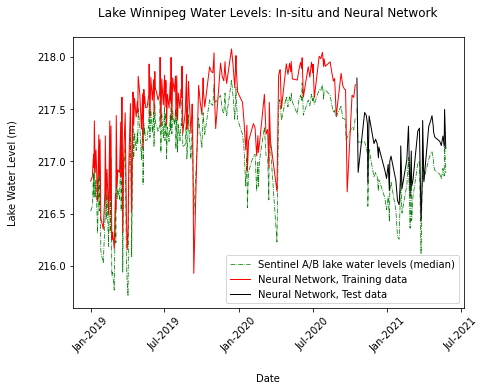

In [39]:
fig = plt.figure(
    figsize=(7, 5)
)
ax = fig.add_subplot(111)
# ax.plot(
#     baseline_train["date"],
#     baseline_train["in_situ_lake_water_level"],
#     color="b",
#     linestyle="--",
#     linewidth=0.5,
#     label="In-situ lake water levels"
# )
# ax.plot(
#     baseline_test["date"],
#     baseline_test["in_situ_lake_water_level"],
#     color="b",
#     linestyle="--",
#     linewidth=0.5,
# #    label="Median of lake water levels, Test"
# )

ax.plot(
    baseline_train["date"],
    baseline_train["lake_water_level"],
    color="g",
    linestyle="-.",
    linewidth=0.75,
    label="Sentinel A/B lake water levels (median)"
)
ax.plot(
    baseline_test["date"],
    baseline_test["lake_water_level"],
    color="g",
    linestyle="-.",
    linewidth=0.75,
#    label="Median of lake water levels, Test"
)
ax.plot(
    baseline_train["date"],
    lake_water_levels_nn_train, # + np.mean(baseline_train["lake_water_level"] - np.mean(lake_water_levels_nn_train)),
    color="r",
    linestyle="-",
    linewidth=1.0,
    label="Neural Network, Training data"
)
ax.plot(
    baseline_test["date"],
    lake_water_levels_nn_test, # + np.mean(baseline_test["lake_water_level"] - np.mean(lake_water_levels_nn_test)),
    color="k",
    linestyle="-",
    linewidth=1.0,
    label="Neural Network, Test data"
)
locator = matplotlib.dates.MonthLocator((1, 7))
fmt = matplotlib.dates.DateFormatter('%b-%Y')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(fmt)
for x in ax.get_xticklabels():
    x.set_rotation(45)
ax.legend()
ax.set_xlabel("Date", labelpad=20)
ax.set_ylabel("Lake Water Level (m)", labelpad=20)
plt.title("Lake Winnipeg Water Levels: In-situ and Neural Network", pad=20)
plt.show()
